In [1]:
from get_bifurcations import get_bifurcations
from scipy.interpolate import UnivariateSpline,interp1d
from scipy.signal import convolve2d

from crnpy.parser import fromcrn
from crnpy.colors import cyan,yellow
from matplotlib.pyplot import *

from numpy import *
from scipy.interpolate import interp2d
from json import loads,dumps

from os import system
from os.path import isfile
from re import finditer,sub,search

from matplotlib.pyplot import *
from matplotlib.legend_handler import HandlerTuple
from numpy import *
from numpy.random import uniform
from scipy.interpolate import interp2d

from numpy.random import normal
from scipy.interpolate import UnivariateSpline
from yaml import load


def save_frame(model,j=0) :

    fig, (ax1, ax3) = subplots(1,2, figsize=(14,8))
    fig.suptitle(r'$t$ = {:.3} hours'.format(model.time), fontsize=16, y=0.15, x=0.63)
    ax2 = twinx(ax1)

    p1 = ax1.fill_between(100*model.space,model.cfp,color='#00b0f0',linewidth=3,alpha=0.5)
    p2 = ax1.fill_between(100*model.space,model.yfp,color='#ffc000',linewidth=3,alpha=0.5)

    p3, = ax2.plot(100*model.space,model.c6,color='#000099',linewidth=5)
    p4, = ax2.plot(100*model.space,model.c12,color='#ff6600',linewidth=5)

    ax1.set_xlabel('space, $x$ / cm',fontsize=16)
    ax1.set_ylabel('concentrations / nM',fontsize=16);
    
    ax1.set_ylim(0,); ax2.set_ylim(0,)
    ax1.set_yticks([]); ax2.set_yticks([])
    xlim(0,1.6)
    
    mask = model.cfp > model.yfp
    ax3.plot(model.c6[mask]+model.c12[mask],model.c6[mask]/model.c12[mask],'.',color='#00b0f0',ms=12)
    ax3.plot(model.c6[~mask]+model.c12[~mask],model.c6[~mask]/model.c12[~mask],'.',color='#ffc000',ms=12)

    ax3.set_xlabel(r'density, $C_{6}$+$C_{12}$ / nM',fontsize=16)
    ax3.set_ylabel(r'ratio, $C_{6}$/$C_{12}$',fontsize=16);

    ax3.set_xscale('log'); ax3.set_yscale('log')
    ax3.set_xlim(0.04,75000); ax3.set_ylim(0.04,75) 
    
    fig.legend([(p1, p2), (p3,p4)], [r'cell responses $CFP$,$YFP$', r'morphogens $C_{6}$,$C_{12}$'],
               handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=16, loc=(0.31,0.08), borderaxespad=0.1)
    subplots_adjust(bottom=0.3)
    savefig(str(j).zfill(4)+'.png')
    close()

    return j+1


def create_animation(C6,C12):
    '''execute system commands to create animation from frames'''
    system('convert -delay 10 -loop 0 *.png c6-{}_c12-{}.gif'.format(C6,C12))
    system('rm *.png')

In [2]:
crn_path = 'models/direct-constant.crn'

model = fromcrn(crn_path)
t_final = 30

C6=100; C12=300
width = model._xmax / 4.0
n_timepoints = 50

# initial condition
model.c6[model.space<width] = model._xmax * C6 / width
model.c12[model.space>=(model._xmax-width)] = model._xmax * C12 / width

j = 0
while model.time < t_final :
    model.time_step() 

    record = int(model.time/model._dt) % int(t_final/model._dt/n_timepoints) == 0
    if record : j = save_frame(model,j)

create_animation(C6,C12)

 [model]  setting spatial directive


In [3]:
figure(figsize=(6,6))

self = fromcrn('models/direct-constant.crn')
for self.c12 in logspace(-2,3,100) :

    while self.time < t_final :
        self.time_step() 

    plot(self.c12,self.capacity*self.aYFP*self.P81,'.',color='gold')
    plot(self.c12,self.capacity*self.aCFP*self.P76,'.',color='darkcyan')

ylabel('Production Rate',fontsize=16)
xlabel('Diffusive Signal, $C_{12}$ / nM',fontsize=16)
xscale('log')
yscale('log')
    
self = fromcrn('models/direct-constant.crn')

self.c12[:] = 0
while model.time < t_final :
    model.time_step() 

figure(figsize=(6,6))
for self.c6 in logspace(-2,6,100) :

    plot(self.c6,self.capacity*self.aYFP*self.P81,'.',color='gold')
    plot(self.c6,self.capacity*self.aCFP*self.P76,'.',color='darkcyan')

ylabel('Production Rate',fontsize=16)
xlabel('Diffusive Signal, $C_{6}$ / nM',fontsize=16)
xscale('log')
yscale('log')

 [model]  setting spatial directive


ValueError: operands could not be broadcast together with shapes (8,101) (8,) 

<Figure size 432x432 with 0 Axes>

In [45]:
from lib.model import Model
from lib.parsers import crn_parameters
from models.doubleExclusive import system_specifications,parameters

from pandas import read_csv
from lib.colors import cyan,yellow

from numpy import meshgrid,log10,genfromtxt
from matplotlib.pyplot import plot,scatter,figure,xlim,ylim,xlabel,ylabel,xscale,yscale,colorbar,pcolor,fill_between,show,legend

crn_path = 'models/direct-constant.crn'
data_path = 'data/liquid/char_ExRep_1_R33S175ExRepTet33AAVLac300ND.csv'
#regions = []

# import mcmc trace
for k in range(8,100) :

    trace = {}
    for column in genfromtxt('data/mcmc/target_posterior.tsv',dtype=str).T :
        trace[column[0]] = column[-k].astype(float)

    parameters.update(trace)
    model = Model(pars = parameters , **system_specifications)

    print('processing',k)
    model.integrate()
    model.get_cusp('c6','c12')

    region = model.bifurcations['LC1']
    regions += [ region.curve[:-1,region.params].T ]



('processing', 8)
finding limit point...
 - forwards
LP Point found 
following limit curve...
 - forwards
CP Point found 
done
('processing', 9)
finding limit point...
 - forwards
LP Point found 
following limit curve...
 - forwards
CP Point found 
done
('processing', 10)
finding limit point...
 - forwards
LP Point found 
following limit curve...
 - forwards
CP Point found 
done
('processing', 11)
finding limit point...
 - forwards
LP Point found 
following limit curve...
 - forwards
CP Point found 
done
('processing', 12)
finding limit point...
 - forwards
LP Point found 
following limit curve...
 - forwards
CP Point found 
done
('processing', 13)
finding limit point...
 - forwards
LP Point found 
following limit curve...
 - forwards
CP Point found 
done
('processing', 14)
finding limit point...
 - forwards
LP Point found 
following limit curve...
 - forwards
CP Point found 
done
('processing', 15)
finding limit point...
 - forwards
LP Point found 
following limit curve...
 - forwards

TypeError: symbolMapClass does not know how to process this type of argument

In [4]:
figure(figsize=(9,7))

liquid_data = read_csv(data_path)
cfp,yfp = liquid_data.pivot('C6','C12','P(ECFP/mRFP1)'), liquid_data.pivot('C6','C12','P(EYFP/mRFP1)')
c12,c6 = meshgrid(cfp.columns.values,cfp.index.values)

c12shift,c6shift = 2*cfp.columns.values, 2*cfp.index.values
pcolor(c12+c12shift,c6+c6shift[:,None],log10(cfp.values),cmap='cyan',vmin=1,vmax=2.1)
colorbar(pad=-0.1,ticks=[1,2,3]).ax.set_yticklabels(['$10^{1}$','$10^{2}$','$10^{3}$'])

pcolor(c12+c12shift,c6+c6shift[:,None],log10(yfp.values),cmap='yellow',vmin=1,vmax=2.1)
colorbar(ticks=[]).ax.set_yticklabels([])

for region_c6,region_c12 in regions :
    fill_between(10**region_c12,10**region_c6,facecolor='none',edgecolor='k',linewidth=2,alpha=0.2)

# flow cytometry points
scatter(1e-1,100,s=200,facecolor='#00b0f0',marker='s',edgecolors='k')
scatter(1e-1,1e-1,s=200,facecolor='white',marker='s',edgecolors='k')
scatter(200,1e-1,s=200,facecolor='#ffc000',marker='s',edgecolors='k')

scatter(25000,8333,s=200,facecolor='#00b0f0',marker='s',edgecolors='k')
scatter(25000,2777,s=200,facecolor='none',marker='s',hatch='///',edgecolors='k')
scatter(25000,926,s=200,facecolor='none',marker='s',hatch='///',edgecolors='k')
scatter(25000,309,s=200,facecolor='#ffc000',marker='s',edgecolors='k')

scatter(5000,2777,s=200,facecolor='#00b0f0',marker='s',edgecolors='k')
scatter(5000,926,s=200,facecolor='none',marker='s',hatch='///',edgecolors='k')
scatter(5000,308,s=200,facecolor='none',marker='s',hatch='///',edgecolors='k')
scatter(5000,102,s=200,facecolor='none',marker='s',hatch='///',edgecolors='k')
scatter(5000,34,s=200,facecolor='#ffc000',marker='s',edgecolors='k')

scatter(1000,926,s=200,facecolor='#00b0f0',marker='s',edgecolors='k')
scatter(1000,308,s=200,facecolor='none',marker='s',hatch='///',edgecolors='k')
scatter(1000,102,s=200,facecolor='none',marker='s',hatch='///',edgecolors='k')
scatter(1000,34,s=200,facecolor='none',marker='s',hatch='///',edgecolors='k')
scatter(1000,11,s=200,facecolor='#ffc000',marker='s',edgecolors='k')

scatter(200,308,s=200,facecolor='#00b0f0',marker='s',edgecolors='k')
scatter(200,100,s=200,facecolor='none',marker='s',hatch='///',edgecolors='k')
scatter(200,34,s=200,facecolor='none',marker='s',hatch='///',edgecolors='k')
scatter(200,11,s=200,facecolor='#ffc000',marker='s',edgecolors='k')

scatter(40,102,s=200,facecolor='#00b0f0',marker='s',edgecolors='k')
scatter(40,34,s=200,facecolor='none',marker='s',hatch='///',edgecolors='k')
scatter(40,11,s=200,facecolor='none',marker='s',hatch='///',edgecolors='k')
scatter(40,3.8,s=200,facecolor='#ffc000',marker='s',edgecolors='k')

scatter(8,34,s=200,facecolor='#00b0f0',marker='s',edgecolors='k')
scatter(8,11,s=200,facecolor='#ffc000',marker='s',edgecolors='k')

yscale('log'); xscale('log')
xlim(0.04,75000); ylim(0.04,75000)

xlabel('Morphogen $C_{12}$ / nM',fontsize=16)
ylabel('Morphogen $C_{6}$ / nM',fontsize=16)

scatter(None,None,s=200,facecolor='None',marker='s',edgecolors='k',label='flow cytometry')
plot([None],[None],linewidth=0,fillstyle='left',marker='s',markersize=15,markeredgewidth=0,markerfacecolor='#ffc000',markerfacecoloralt='#00b0f0',label='plate reader')
scatter(None,None,s=200,facecolor='white',marker='s',edgecolors='none',hatch='///',label='model')
legend(fontsize=16,loc=2)

NameError: name 'read_csv' is not defined

<Figure size 648x504 with 0 Axes>

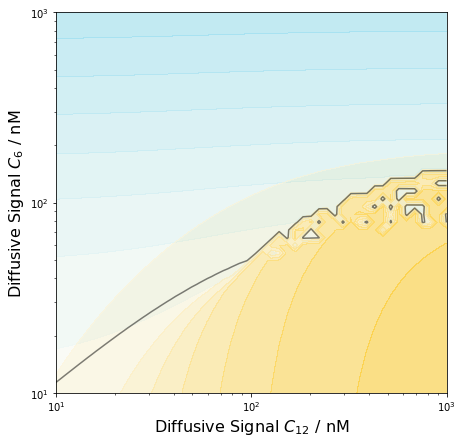

In [6]:
figure(figsize=(7,7))

contourf(c12,c6,cfp,cmap='cyan',alpha=0.5)
contourf(c12,c6,yfp,cmap='yellow',alpha=0.5)
contour(c12,c6,yfp-cfp,levels=[0.0],colors=['k'],alpha=0.5)

xscale('log'); yscale('log')
xlabel(r'Diffusive Signal $C_{12}$ / nM',fontsize=16)
ylabel(r'Diffusive Signal $C_{6}$ / nM',fontsize=16);

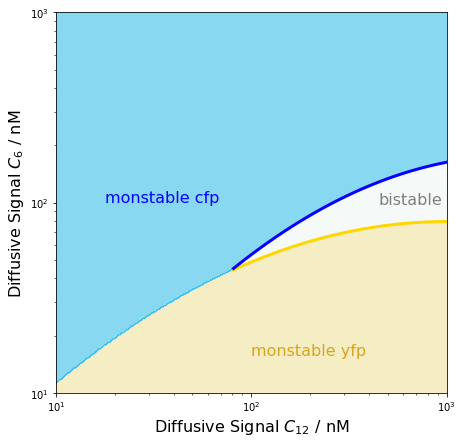

In [7]:
figure(figsize=(7,7))

def f(z) :
    return 10**(1.05+(log10(z)-1)*(5-log10(z))/4.7)

def g(z) :
    u = f(z)
    v = 10**(1.47+(log10(z)-1.7)*(5-log10(z))/3.5)
    if u > v :
        return u
    else :
        return v
    
g = vectorize(g)
c12,c6 = meshgrid(logspace(1,3,300),logspace(1,3,300))

contourf(c12,c6,f(c12)>c6,cmap='yellow',alpha=0.5)
contourf(c12,c6,g(c12)<c6,cmap='cyan',alpha=0.5)

z = logspace(0,3,100)
mask = f(z) != g(z)

plot(z[mask],f(z)[mask],'gold',linewidth=3)
plot(z[mask],g(z)[mask],'b',linewidth=3)

xscale('log'); yscale('log')
xlabel(r'Diffusive Signal $C_{12}$ / nM',fontsize=16)
ylabel(r'Diffusive Signal $C_{6}$ / nM',fontsize=16)

text(10**1.25,10**2,'monstable cfp',fontsize=16,color='b')
text(10**2,10**1.2,'monstable yfp',fontsize=16,color='goldenrod')
text(10**2.65,10**1.99,'bistable',fontsize=16,color='gray');

In [8]:
def generate_frame(j,model):
    '''main program figure display'''

    figure(figsize=(10,10))
    mask = model.cfp > model.yfp

    contourf(c6,c12,cfp,
             cmap='cyan',alpha=0.5)
    contourf(c6,c12,yfp,
             cmap='yellow',alpha=0.5)
    contour(c6,c12,yfp-cfp,levels=[0.0],
             colors=['k'],alpha=0.5)

    xscale('log'); yscale('log')
    xlabel(r'Diffusive Signal $C_{6}$ / nM',fontsize=16)
    ylabel(r'Diffusive Signal $C_{12}$ / nM',fontsize=16)

    plot(model.c6[mask],model.c12[mask],'.',color='darkcyan',ms=12)
    plot(model.c6[~mask],model.c12[~mask],'.',color='gold',ms=12)

    plot(C6,C12,'.',color='k',ms=20)
    text(C6,C12,'  steady state',fontsize=16)

#     xlim(10**1, 10**3)
#     ylim(10**1, 10**3)

    savefig(str(j).zfill(4)+'.png')
    close()

    return j+1
    
def create_animation(C6,C12):
    '''execute system commands to create animation from frames'''
    system('convert -delay 10 -loop 0 *.png c6-{}_c12-{}.gif'.format(C6,C12))
    system('rm *.png')

In [424]:
crn_path = 'direct-constant.crn'
N = 50

C6grid,C12grid = meshgrid(logspace(1,3,N),logspace(1,3,N))
distances = zeros_like(C6grid)

for i in range(N) :
    for j in range(N) :
        model = fromcrn(crn_path)

        C6=C6grid[i,j]; C12=C12grid[i,j]
        width = model._xmax / 4.0
        n_timepoints = 50

        # initial condition
        model.c6[model.space<width] = model._xmax * C6 / width
        model.c12[model.space>=(model._xmax-width)] = model._xmax * C12 / width

#         figure(figsize=(7,7))
#         title('initial and final $C_{6}(x)$, $C_{12}(x)$ profiles',fontsize=16,y=1.02)
#         plot(model.space,model.c6,color='darkcyan')
#         plot(model.space,model.c12,color='gold')
#         plot(nan,nan,color='k',label='$t=${:.0f}h'.format(model.time))

#         yscale('log'); ylim(10,10**4)
#         xlabel('space, $x$ / cm',fontsize=16)
#         ylabel('concentrations / nM',fontsize=16)

        # # create bifrucation figure
        cfp_traj = []
        yfp_traj = []
#         time_traj = []

        while model.time < model._final :
            model.time_step() 

            record = int(model.time/model._dt) % int(t_final/model._dt/n_timepoints) == 0
            if record and model.time > 5.0 :

                cfp_traj += [model.cfp]
                yfp_traj += [model.yfp]
#                 time_traj += [model.time]

        cfp_traj = array(cfp_traj)
        yfp_traj = array(yfp_traj)
#         time_traj = array(time_traj)

#         plot(model.space,model.c6,color='darkcyan',linewidth=3)
#         plot(model.space,model.c12,color='gold',linewidth=3)
#         plot(nan,nan,color='k',linewidth=3,label='$t=${:.0f}h'.format(model.time))
#         legend(fontsize=16);

        boundary_index = argmin(abs((yfp_traj-cfp_traj)),axis=1)
        distances[i,j] = (model.space[boundary_index[-1]]-model.space[boundary_index[0]])/model._xmax

 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial di

 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial di

 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial di

 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial di

 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial di

 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial di

 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial di

 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial di

 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial di

 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial di

 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial di

 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial di

 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial di

 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial directive
 [model]  setting spatial di

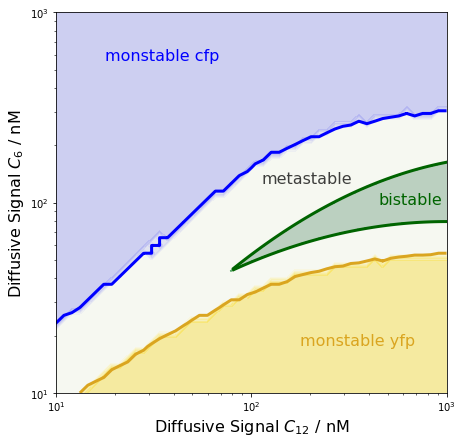

In [425]:
figure(figsize=(7,7))
# contourf(C12grid,C6grid,log(distances),cmap='cyan',alpha=0.5)
# contourf(C12grid,C6grid,log(-distances),cmap='yellow',alpha=0.5)

percentage=0.1
contourf(C12grid,C6grid,distances>percentage,cmap='cyan',alpha=0.5)
contourf(C12grid,C6grid,distances<-percentage,cmap='yellow',alpha=0.5)

contour(C12grid,C6grid,distances,levels=[percentage],colors=['blue'],linewidths=[3])
contour(C12grid,C6grid,-distances,levels=[percentage],colors=['goldenrod'],linewidths=[3])

c12,c6 = meshgrid(logspace(1,3,300),logspace(1,3,300))
mask = f(z) != g(z)

plot(z[mask],f(z)[mask],'darkgreen',linewidth=3)
plot(z[mask],g(z)[mask],'darkgreen',linewidth=3)

contourf(c12,c6,(f(c12)<c6)&(g(c12)>c6),cmap='Greens',alpha=0.25)

xscale('log'); yscale('log')
xlabel(r'Diffusive Signal $C_{12}$ / nM',fontsize=16)
ylabel(r'Diffusive Signal $C_{6}$ / nM',fontsize=16)

text(10**1.25,10**2.75,'monstable cfp',fontsize=16,color='b')
text(10**2.25,10**1.25,'monstable yfp',fontsize=16,color='goldenrod')

text(10**2.05,10**2.10,'metastable',fontsize=16,color='k',alpha=0.75);
text(10**2.65,10**1.99,'bistable',fontsize=16,color='darkgreen');

In [4]:
figure(figsize=(7,7))
mask = model.cfp > model.yfp

contourf(c12,c6,cfp,
         cmap='cyan',alpha=0.5)
contourf(c12,c6,yfp,
         cmap='yellow',alpha=0.5)
contour(c12,c6,yfp-cfp,levels=[0.0],
         colors=['k'],alpha=0.5)

xscale('log'); yscale('log')
ylabel(r'Diffusive Signal $C_{6}$ / nM',fontsize=16)
xlabel(r'Diffusive Signal $C_{12}$ / nM',fontsize=16)

# burn_in = 0
# downsample = 7

# # cfpmask = all((cfp_traj>yfp_traj)[burn_in:],axis=0)
# # plot(c12_traj[:,cfpmask][:,::downsample],c6_traj[:,cfpmask][:,::downsample],color='darkcyan')

# # yfpmask = all((cfp_traj<yfp_traj)[burn_in:],axis=0)
# # plot(c12_traj[:,yfpmask][:,::downsample],c6_traj[:,yfpmask][:,::downsample],color='gold')

# # mask = (~yfpmask) & (~cfpmask)
# # plot(c12_traj[:,mask][:,::downsample],c6_traj[:,mask][:,::downsample],color='grey',linewidth=3)


mask = (cfp_traj<yfp_traj)
plot(c12_traj[mask],c6_traj[mask],'.',color='gold')

plot(c12_traj[~mask],c6_traj[~mask],'.',color='darkcyan')

plot(C12,C6,'.',color='k',ms=20)
text(C12,C6,'  steady state',fontsize=16)

xlim(10**1, 10**3)
ylim(10**1, 10**3);

NameError: name 'model' is not defined

<Figure size 504x504 with 0 Axes>

In [137]:
c12_traj.shape

(9600, 101)

In [ ]:
model = fromcrn(crn_path)

def PLac(L) :
    return model.aS175/(1+L**model.nL)

def PTet(T) :
    return model.aR33 / (1+T**model.nT)

def P76(R,S,c6,c12) :

    R = boundLuxR(R,c6,c12)
    S = boundLasR(S,c6,c12)

    return model.aL*(model.e76 + model.KGR_76*R + model.KGS_76*S) / \
           (1+model.KGR_76*R + model.KGS_76*S)

def P81(R,S,c6,c12) :

    R = boundLuxR(R,c6,c12)
    S = boundLasR(S,c6,c12)

    return model.aT*(model.e81 + model.KGR_81*R + model.KGS_81*S) / \
           (1+model.KGR_81*R + model.KGS_81*S)

def boundLuxR(R,c6,c12) :
    return R**2 * ( model.KR6*c6**model.nR + model.KR12*c12**model.nR ) / (1 + model.KR6*c6 + model.KR12*c12) ** model.nR
    
def boundLasR(S,c6,c12) :
    return S**2 * ( model.KS6*c6**model.nS + model.KS12*c12**model.nS ) / (1 + model.KS6*c6 + model.KS12*c12) ** model.nS

x = linspace(0,20,100)
figure(figsize=(5,5))

model = fromcrn(crn_path)
plot(x,PTet(x),color='darkcyan',label='PTet',linewidth=3)
plot(x,PLac(x),color='darkorange',label='PLac',linewidth=3)

ylabel('Promoter Activity',fontsize=16)
xlabel('Repressor Concentration',fontsize=16)
legend(fontsize=16); yscale('log');

In [ ]:
crn_path = 'double-exclusive.crn'

cfp_population = []
yfp_population = []
x_population = []
f500_population = []
f430_population = []
growth_population = []

for _ in range(100) :
    
    model = fromcrn(crn_path)
    model._dt = mean(diff(time_data))/10

    i,j = 0,2
    model.c6 = c6_data[i,j] 
    model.c12 = c12_data[i,j] 
    yfp_data,cfp_data = traces[i,j]

    model.lacI = random.normal(loc=1,scale=0.1)
    model.tetR = random.normal(loc=1,scale=0.1)

    cfp = []
    yfp = []
    x = []
    growth = []
    f500 = []
    f430 = []
    time = []

    for i in range(int(10*time_data.size)) :

        if i % 10 == 0 :

            x += [model.x]
            f430 += [model.f430]
            f500 += [model.f500]
            # 
            # 
            cfp += [ model.x*(model.cfp + model.f430) + model.cb0_exrep]
            yfp += [ model.x*(model.yfp + model.f500) + model.yb0_exrep ]
            growth += [ model.growth ]
            time += [model.time]

        model.time_step()
        i += 1
    
    cfp_population += [cfp]
    yfp_population += [yfp]
    x_population += [x]
    growth_population += [growth]
    f500_population += [f500]
    f430_population += [f430]
    
cfp_population = array(cfp_population)
yfp_population = array(yfp_population)
x_population = array(x_population)
growth_population = array(growth_population)
f500_population = array(f500_population)
f430_population = array(f430_population)

fig,ax1 = subplots(figsize=(5,5))
ax2 = twinx(ax1)
ax1.plot(time_data,yfp_data,'.',color='gold',linewidth=3)
ax1.plot(time_data,cfp_data,'.',color='darkcyan',linewidth=3)
        
ax1.plot(time,(cfp_population).T,color='darkcyan',linewidth=3,alpha=0.2)
ax1.plot(time,(yfp_population).T,color='gold',linewidth=3,alpha=0.2)
ax2.fill_between(time,x_population[0],color='black',alpha=0.06)
        
title('$C_{6} = $'+str(model.c6)+ \
      ' nM   '+'$C_{12}$ = '+str(model.c12)+' nM',
      fontsize=16,y=1.02)
ax1.set_ylabel('Concentration',fontsize=16)
ax2.set_ylabel('Population',fontsize=16)
ax1.set_xlabel('Time, $t$ / h',fontsize=16);
# ax1.set_yticks([]);

In [ ]:
fig,ax1 = subplots(figsize=(5,5))
ax2 = twinx(ax1)
# ax1.plot(time_data,yfp_data,'.',color='gold',linewidth=3)
# ax1.plot(time_data,cfp_data,'.',color='darkcyan',linewidth=3)
        
ax1.plot(time,(cfp_population).T,color='darkcyan',linewidth=3,alpha=0.2)
ax1.plot(time,(yfp_population).T,color='gold',linewidth=3,alpha=0.2)
ax2.fill_between(time,x_population[0],color='black',alpha=0.06)
        
title('$C_{6} = $'+str(model.c6)+ \
      ' nM   '+'$C_{12}$ = '+str(model.c12)+' nM',
      fontsize=16,y=1.02)
ax1.set_ylabel('Concentration',fontsize=16)
ax2.set_ylabel('Population',fontsize=16)
ax1.set_xlabel('Time, $t$ / h',fontsize=16);

In [ ]:
plot(time[:],x_population[0,:])
plot(time[:],growth_population[0,:])

plot(time[:60],x_population[0,:60])
plot(time[:60],growth_population[0,:60])

In [ ]:
x_population[0,40],growth_population[0,40]

In [ ]:
raw_data = genfromtxt('R33S175ExRepTet33AAVLac300ND_EYFP_ECFP_proc_R33S175ExrepTet33AAVLac300ND.txt',
                      delimiter='\t',dtype=str)

time_data = raw_data[1:,0].astype(float)

In [ ]:
from collections import defaultdict

traces = []
for trace in raw_data.T[1:].reshape(36,2,101) :
    
    yfp_header,cfp_header = trace[:,0]
    yfp_header = yfp_header[3:].replace(')','}').replace('(','{') \
                 .replace('=',':').replace(';',',') \
                 .replace('C6','"C6"').replace('C12','"C12"') \
                 .replace('No conditions','')
    cfp_header = cfp_header[3:].replace(')','}').replace('(','{') \
                 .replace('=',':').replace(';',',') \
                 .replace('C6','"C6"').replace('C12','"C12"') \
                 .replace('No conditions','')
                
    signals = defaultdict(lambda: 0.0)
    signals.update(load(yfp_header))

    traces += [trace[:,1:]]

c = append([0.0],2.5*logspace(0,4,5))
c6_data,c12_data = meshgrid(c[::-1],c[::-1])
    
traces = array(traces).astype(float)
traces = traces.reshape(6,6,2,100)
traces = transpose(traces,axes=(1,0,2,3))
ratio = (amax(traces,axis=3)[:,:,0]-amax(traces,axis=3)[:,:,1])/(amax(traces,axis=3)[:,:,0]+amax(traces,axis=3)[:,:,1])

figure(figsize=(5,5))
title('ATC = {} nM     IPTG = {} nM'.format(atc,iptg),
      fontsize=16,y=1.02)

imshow(amax(traces,axis=3)[::-1,::-1,0],
       cmap='yellow',alpha=1,vmax=5e4,origin='bottom')
imshow(amax(traces,axis=3)[::-1,::-1,1],
       cmap='cyan',alpha=0.6,vmax=10e4,origin='bottom')
# xscale('log')
# yscale('log')

xlabel(r'Diffusive Signal $C_{6}$ / nM',fontsize=16)
ylabel(r'Diffusive Signal $C_{12}$ / nM',fontsize=16);
xticks(range(6),[0,2.5,25,250,2500,25000])
yticks(range(6),[0,2.5,25,250,2500,25000]);
plot(0,5,'kx');

In [ ]:
imshow(log10(c6+1e-3),cmap='YlGn')

In [ ]:
imshow(log10(c12+1e-3),cmap='YlGn')

In [ ]:
c6

In [ ]:
z = array([(1.23911009449117,2.53767545512434),
 (1.15517733125013,2.90623966466317),
 (1.13535949246357,2.9439936296521),
 (1.15016734711252,2.96479077809697),
 (1.08178482135368,2.8973597838291),
 (1.04309366969593,2.90236794920261),
 (1.32775020474522,2.55030712124279),
 (1.21527793317182,2.84690988235861),
 (1.1992525561555,2.78618866494784),
 (1.1124185785338,2.89923554052014),
 (1.14167967392581,2.9352920363725),
 (1.14038443011681,2.75676373636988),
 (1.25186206124009,2.57718915047091),
 (1.16856079205105,2.77193096953376),
 (1.15699932748627,2.6545732389709),
 (1.0934526618972,2.81949098456325),
 (1.0902432418606,2.75018569753538),
 (1.13413492044859,2.73145119244249),
 (1.22721751041325,2.71752472339327),
 (1.17804227269233,2.72347549164113),
 (1.15036016519781,2.73182030950349),
 (1.1330079545945,2.78942557495503),
 (1.16003029370348,2.76367647067387),
 (1.16071223455979,2.61671392338562),
 (1.20100205540207,2.55569154616201),
 (1.13116088083604,2.72559067011794),
 (1.08649256548943,2.75602598304217),
 (1.10266592554659,2.76733339027554),
 (1.10132181256971,2.76225223874545),
 (1.11537792648394,2.63199499726725),
 (1.14773254010868,2.71043265999019),
 (1.09125694551481,2.75847335370228),
 (1.08713201799901,2.77416550948362),
 (1.13515992036568,2.74632933831906),
 (1.17249418570909,2.51602588198599)
])
std(z,axis=0)

In [ ]:
atc = linspace(0,45,7)
iptg = linspace(0,0.275,7)

In [ ]:
print(atc)
print(iptg)

In [ ]:
n = 7
atc = linspace(0,45,n)
iptg = linspace(0,0.275,n)

ATC,IPTG = meshgrid(atc,iptg)
IPTG = IPTG[::-1]

fig, ax = subplots(nrows=n, ncols=n, sharex=True, sharey=True,
          squeeze=True, subplot_kw={'xticks': [], 'yticks': [],'xscale': 'log',  'yscale': 'log'},
          gridspec_kw=None,figsize=(2*n,2*n))

for i in range(atc.size):
    for j in range(iptg.size):
        
        c6,c12,cfp,yfp = get_bifurcations(
            crn_path,atc=ATC[i,j],iptg=IPTG[i,j],N=70,
            c6_range=[1,4],c12_range=[1,4])

        ax[i,j].contourf(c6,c12,cfp,
                 cmap='cyan',alpha=0.5)
        ax[i,j].contourf(c6,c12,yfp,
                 cmap='yellow',alpha=0.5)
        ax[i,j].contour(c6,c12,cfp-yfp,levels=[0.0],
                 colors=['k'],alpha=0.5)


# common axes
fig.add_subplot(111, frameon=False)
tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ylabel("[IPTG] Concentration",fontsize=16); xlabel("[ATC] Concentration",fontsize=16);

In [6]:
crn_path = 'direct-constant.crn'
C6=1e4;C12=120
atc,iptg = 0,0.3

t_final = 500
width = 0.01

# import model from file
model = fromcrn(crn_path)
model._dt = 1e-1
n_timepoints = 100

# initial condition
model.c6[model.space<width] = model._xmax * C6 / width
model.c12[model.space>(model._xmax-width)] = model._xmax * C12 / width
model.atc = atc
model.iptg = iptg

c6,c12,cfp,yfp,_ = get_bifurcations(crn_path,atc=atc,iptg=iptg,N=70)

# # create bifrucation figure
# i,j = 0,0
# while model.time < t_final :

#     model.time_step()    
#     if int(model.time/model._dt) % int(t_final/model._dt/n_timepoints) == 0 :
#         j = generate_frame(j,model)
#     i += 1

# create_animation(C6,C12)

AttributeError: can't set attribute

In [ ]:
traces[0]

In [ ]:
fig = figure(figsize=(10,5))
ax2 = fig.add_subplot(122)
mask = model.cfp > model.yfp

ax2.contourf(c6,c12,
         cfp,
         cmap='cyan',alpha=0.5)
ax2.contourf(c6,c12,
         yfp,
         cmap='yellow',alpha=0.5)
ax2.contour(c6,c12,
         yfp-cfp,levels=[0.0],
         colors=['k'],alpha=0.5)

ax2.set_xscale('log'); ax2.set_yscale('log')

ax2.plot(model.c6[mask],model.c12[mask],'.',color='darkcyan',ms=12)
ax2.plot(model.c6[~mask],model.c12[~mask],'.',color='gold',ms=12)

ax2.plot(C6,C12,'.',color='k',ms=20)
ax2.text(C6,C12,'  steady state',fontsize=16)
ax2.set_xlim(10**-0.5, 10**5)
ax2.set_ylim(10**-0.5, 10**5)

ax2.set_xlabel(r'Diffusive Signal $C_{6}$ / nM',fontsize=16)
ax2.set_ylabel(r'Diffusive Signal $C_{12}$ / nM',fontsize=16);

In [ ]:
fig = figure(figsize=(30,15))
ax1 = fig.add_subplot(121)

ax1.plot(model.space,model.cfp,'-',color='darkcyan',
     label='[CFP]',linewidth=6)

ax1.plot(model.space,model.yfp,'-',color='gold',
     label='[YFP]',linewidth=6)

for _ in range(20) :
    ss = model.get_steady_state(array([model.c6,model.c12]).T).T
    Lattractor = ss[model.nontrivials.index('cfp')]
    Tattractor = ss[model.nontrivials.index('yfp')]

    ax1.plot(model.space,Lattractor,'.',alpha=0.5,color='darkcyan')
    ax1.plot(model.space,Tattractor,'.',alpha=0.5,color='gold')

ax1.legend(fontsize=16,loc=1)

xticks(fontsize=16)
yticks(fontsize=16)
ax1.set_yscale('log')

ax1.set_xlabel(r'Space, $x$ / cm',fontsize=24)
ax1.set_ylabel(r'Signal Concentration / nM',fontsize=24)
ax1.legend(fontsize=24)

In [ ]:
fig = figure(figsize=(30,15))
ax1 = fig.add_subplot(121)

Lattractor = array([
    L[argmin(abs(c12[:,0]-c12x)),argmin(abs(c6[0]-c6x))]
    for c6x,c12x in zip(model.c6,model.c12) ]).reshape(-1)

Tattractor = array([
    T[argmin(abs(c12[:,0]-c12x)),argmin(abs(c6[0]-c6x))]
    for c6x,c12x in zip(model.c6,model.c12) ]).reshape(-1)

space = linspace(0,self._xmax,len(Lattractor))
Tindex = argsort(Tattractor)
Lindex = argsort(Lattractor)

mask = model.lacI > model.tetR

ax1.plot(model.space,model.lacI,'.',color='darkcyan',ms=12)
ax1.plot(model.space,model.tetR,'.',color='gold',ms=12)

# ax1.plot(model.space[mask],model.lacI[mask],'.',color='darkcyan',ms=12,label=r'$L(x,t)$')
# ax1.plot(model.space[~mask],model.tetR[~mask],'.',color='gold',ms=12,label=r'$T(x,t)$')

ax1.plot(space[Lindex],Lattractor[Lindex],'o', mfc='none',
         color='darkcyan',linewidth=3)
ax1.plot(space[Tindex],Tattractor[Tindex],'o', mfc='none',
         color='gold',linewidth=3)  

xticks(fontsize=16)
yticks(fontsize=16)
ax1.set_ylim(-2,2)

ax1.set_xlabel(r'Space, $x$ / cm',fontsize=24)
ax1.set_ylabel(r'Concentration / nM',fontsize=24)
ax1.legend(fontsize=24)

In [ ]:
for i,value in enumerate(linspace(0,5,100)):

    file_path = 'new.crn'
    self = fromcrn(file_path)

    self.growth = value

    N = 120

    c6_range = [-0.5,9]
    c12_range = [-0.5,7]

    c = logspace(*c6_range,num=N)
    cdash = logspace(*c12_range,num=N)

    # c6_range = [0,3]
    # c12_range = [0,3]

    # c = linspace(*c6_range,num=N)
    # cdash = linspace(*c12_range,num=N)

    c6,c12 = meshgrid(c,cdash,copy=False)
    c_grid = dstack([c6,c12])

    # calculation of steady states
    steady_state = self.get_steady_state(c_grid,logspace=True)

    T = steady_state[:,:,self.nontrivials.index('tetR')]
    L = steady_state[:,:,self.nontrivials.index('lacI')]

    figure(figsize=(7,7))
    title('growth = {0:.2f}, capacity = {1:.2f} '
          .format(self.growth,self.capacity),fontsize=16)


    contourf(c6,c12,
             L,
             cmap='cyan',alpha=0.5)
    contourf(c6,c12,
             T,
             cmap='yellow',alpha=0.5)
    contour(c6,c12,
             T-L,levels=[0.0],
             colors=['k'],alpha=0.5)
    xscale('log')
    yscale('log')

    xlabel(r'Diffusive Signal $C_{6}$ / nM',fontsize=16)
    ylabel(r'Diffusive Signal $C_{12}$ / nM',fontsize=16);

    savefig(str(i).zfill(3)+'.png')
    close()